RF to predict tti or log tti or ahd from all other data
 use households until find pop
dimensionality reduction?

factorsd impacting congestion, networks, tti, modeshares

tti website has other papers
modeshare variables
feature importance what is the direction of impact (negative vs. positive, impurity)
plot to show errors from rf optimization, 2d contour plot
rf/gbm as feature extractor
pca, condense and explain
kernel pca
update manuscript
final model (generalize additive model)
poster

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

# set pandas column display to none
pd.set_option('display.max_columns', None)

In [2]:
# install scikit-learn
# !pip install scikit-learn

                                              0.0/9.2 MB ? eta -:--:--
                                              0.0/9.2 MB ? eta -:--:--
                                              0.0/9.2 MB 435.7 kB/s eta 0:00:22
                                              0.1/9.2 MB 939.4 kB/s eta 0:00:10
                                              0.2/9.2 MB 1.2 MB/s eta 0:00:08
     -                                        0.3/9.2 MB 1.5 MB/s eta 0:00:07
     -                                        0.4/9.2 MB 1.6 MB/s eta 0:00:06
     --                                       0.5/9.2 MB 1.6 MB/s eta 0:00:06
     --                                       0.6/9.2 MB 1.8 MB/s eta 0:00:05
     ---                                      0.7/9.2 MB 1.9 MB/s eta 0:00:05
     ---                                      0.9/9.2 MB 2.0 MB/s eta 0:00:05
     ----                                     0.9/9.2 MB 1.9 MB/s eta 0:00:05
     ----                                     1.1/9.2 MB 2.0 MB/s eta 0:00

In [4]:
trf = pd.read_csv('../../data/tidy/tti-traffic19-renamed.csv')
net = pd.read_csv('../../data/tidy/data-aggregation-networkstats.csv')
inc = pd.read_csv('../../data/tidy/acs19-hh-income.csv')
mod = pd.read_csv('../../data/tidy/acs19-modeshares.csv')
unemp = pd.read_csv('../../data/tidy/acs19-unemp.csv')
pop = pd.read_csv('../../data/tidy/acs19-pop.csv')

In [5]:
df = trf.merge(net, on='msa', how='left')
df = df.merge(mod, left_on='msa', right_on='msa', how='inner')
df = df.merge(unemp, left_on = 'msa', right_on = 'msa', how = 'left')
df = df.merge(inc, left_on = 'msa', right_on = 'msa', how = 'left')
df = df.merge(pop, left_on = 'msa', right_on = 'msa', how = 'left')
df = df.dropna(subset=['tti'])
# df = df.set_index('msa')
# df['log_tti'] = np.log10(df['tti'])


In [6]:
from pathlib import Path  
filepath = Path('../../data/tidy/congestion-exploration19_MM.csv', index = False)  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath)

# Perform PCA with GAM

In [7]:
data = df.copy()
data.head()

,msa,auto_commuters,annual_excess_fuel_consumed_commuters,ahd_ph,tti,n,m,k_avg,edge_length_total,edge_length_avg,streets_per_node_avg,intersection_count,street_length_total,street_segment_count,street_length_avg,circuity_avg,self_loop_proportion,node_density_km,intersection_density_km,edge_density_km,street_density_km,builing_area_sqkm,area_sqkm,ms_cara_per,ms_carp_per,ms_pt_per,ms_taxi_per,ms_bike_per,ms_walk_per,ms_wfh_per,unemp,med_hh_inc_dol,households,population
0,"Abilene, TX",64,1282,2548,1.07,14357,39401,5.488751,1.716897e+07,435.749497,2.881452,11912,8.925436e+06,20606,433.147439,1.067840,0.004465,2.012523,1.669790,2406.696840,1251.142264,7.048505,7133.829924,80.291133,100.105752,0.510579,0.915432,0.265604,1.943037,5.499039,3.4,52511,60931,170669
1,"Akron, OH",298,6741,15835,1.10,26865,70900,5.278243,1.519199e+07,214.273426,2.756896,21200,8.039295e+06,36980,217.395754,1.056240,0.015089,11.231303,8.862967,6351.230011,3360.943838,14.307097,2391.975398,84.673598,100.071737,1.303214,0.614118,0.096859,1.592914,4.545640,5.4,57285,286543,703845
2,"Albany, GA",54,870,1905,1.08,8466,22838,5.395228,9.545102e+06,417.948256,2.837468,6957,4.989593e+06,11954,417.399446,1.052833,0.002928,2.028965,1.667318,2287.583389,1195.808038,6.979580,4172.570196,81.190732,100.114382,0.995359,0.906248,0.131145,1.585513,3.752774,10.6,44844,55714,148436
3,"Albany-Lebanon, OR",35,465,1046,1.06,7132,17906,5.021312,8.280294e+06,462.431276,2.568144,5101,4.225439e+06,9147,461.948061,1.150205,0.005466,1.193324,0.853498,1385.456359,706.999160,7.519705,5976.582645,79.296969,100.111969,0.170747,1.503313,0.645868,2.225274,4.960932,6.6,55893,47762,125048
4,"Albany-Schenectady-Troy, NY",297,6240,15617,1.15,36977,96867,5.239311,2.787244e+07,287.739291,2.755794,30254,1.455542e+07,50900,285.961192,1.091565,0.033320,4.962653,4.060365,3740.737967,1953.471821,41.455466,7451.054339,79.338492,100.080156,3.618297,0.859834,0.280518,3.332137,4.555087,4.6,71285,352713,880736


- Before performing PCA, we need to normalize the data. PCA is a variance maximizing exercise. It projects your original data onto directions which maximize the variance. If some variables are measured on a large scale compared to others, they could end up dominating the principal components, even if they are not interesting.

- After the normalization, we'll perform PCA. For simplicity, we'll drop the "msa" column as it is a string and doesn't contribute to the PCA calculation. It's not a numerical feature that can be used in the PCA, GBM, or GAM calculations. We can always map back the results to the respective areas later if needed.

In [8]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Drop the 'msa' column
data_numeric = data.drop('msa', axis=1)

# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Perform PCA
pca = PCA()
data_pca = pca.fit_transform(data_scaled)

# Convert to DataFrame
data_pca_df = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(data_pca.shape[1])])

# Display the first few rows
data_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33
0,-1.940668,1.014809,-1.752532,1.414017,-0.379620,-0.884817,-0.429983,0.532106,-0.571571,0.226616,1.024352,-0.390007,-0.498652,-0.555291,-0.057688,-0.374815,-0.265514,-0.024885,-0.074934,-0.018866,-0.111120,0.009291,-0.004617,-0.025144,0.016406,-0.009789,-0.004579,0.008417,0.002609,0.004340,0.002191,0.000486,-5.065872e-14
1,1.233214,-4.898107,0.345507,0.564205,-0.583193,-0.073386,0.261502,-0.220914,-0.162573,0.396873,0.428085,0.563984,0.141702,-0.030933,0.533081,-0.497425,0.177907,-0.133606,-0.061583,0.226157,0.127320,0.021870,-0.054616,0.036824,-0.000932,-0.003341,-0.009412,0.010692,-0.005563,-0.004613,-0.007776,-0.004346,-1.325123e-13
2,-2.474087,0.438157,-2.602545,0.055072,2.245417,1.365066,-0.452235,-1.130635,-0.447159,-0.121429,0.760367,1.414604,-0.145999,0.401617,-0.608533,0.412809,-0.211677,0.082501,0.018810,-0.172697,-0.029150,0.020207,0.045948,-0.002835,0.015257,0.012049,0.010411,0.000566,0.003472,0.002333,0.002852,-0.001157,3.914195e-14
3,-2.757624,2.631257,0.165466,-1.158935,0.216518,1.019868,-0.667369,0.591898,-0.565602,0.185503,1.044322,0.343113,0.408140,-0.543620,-0.219128,0.551948,0.294733,-0.053303,0.016913,0.161253,0.028849,0.002546,-0.027832,-0.009785,-0.013716,0.002459,0.018221,-0.008966,-0.001881,-0.004751,-0.001000,0.000336,-5.566656e-14
4,1.195734,-0.938786,1.381828,1.091793,-1.522450,-0.242383,2.126378,-0.635939,-1.389907,-2.077085,0.255387,0.200649,1.343173,-0.321356,0.265588,0.344853,-0.553010,-0.178494,-0.384671,-0.235515,0.028136,-0.030130,-0.052114,-0.036170,-0.006688,-0.011685,-0.000799,0.013573,-0.002188,0.002776,0.006519,0.001312,2.256969e-14


- The resulting dataframe, data_pca_df, consists of the principal components (PCs). Each PC is a linear combination of the original features, and they're ordered by the amount of original variance they capture.

- Visualize the explained variance ratio to decide how many PCs to keep. This will help us determine the optimal number of PCs that capture most of the variance in the data, which is a common approach when using PCA for dimensionality reduction.

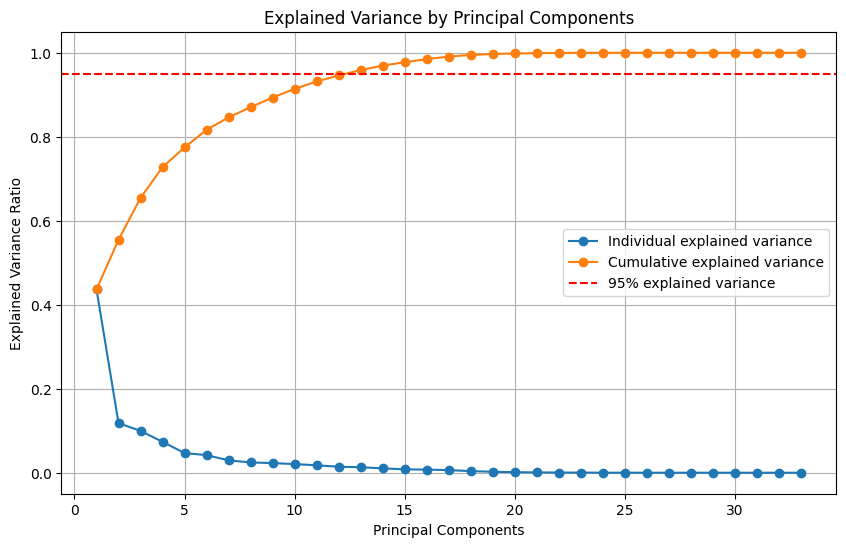

In [9]:
import matplotlib.pyplot as plt

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the explained variance
ax.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Individual explained variance')

# Plot the cumulative explained variance
ax.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, marker='o', label='Cumulative explained variance')

# Add a horizontal line at y=0.95
ax.axhline(y=0.95, color='r', linestyle='--', label='95% explained variance')

# Add labels and title
ax.set_ylabel('Explained Variance Ratio')
ax.set_xlabel('Principal Components')
ax.set_title('Explained Variance by Principal Components')

# Add legend
ax.legend()
# add grid
ax.grid()

# Show the plot
plt.show()


- The plot shows the explained variance ratio of each principal component (PC) and the cumulative explained variance. The red dashed line represents the point at which 95% of the total variance in the data is explained. The goal is to retain the fewest possible PCs while capturing the highest possible total variance.
- We can see that around 12 PCs are needed to capture 95% of the variance in the data. This reduces the number of features from 32 to 12, which could help with computational efficiency and mitigate the risk of overfitting when training our GBM and GAM models. However, it's also important to note that interpretability may be compromised, as each PC is a combination of the original features and may not hold a direct, meaningful interpretation in the context of the data

--------------------------------------
# For better interpretability of PCA:

- Each PC is a linear combination of the original features. The PCs are constructed in such a way that the first PC accounts for the largest possible variance in the data, the second PC accounts for the second largest variance, and so on. Thus, the original features are not directly selected; rather, they are transformed into a new set of features (the PCs) that are linear combinations of the original ones.

- Given this transformation, it's not straightforward to directly interpret the original features from the PCs. However, we can examine the coefficients of the original features in the calculation of each PC (also known as the loadings), which can give us some insight into which original features contribute most to each PC. We'll do this analysis after performing PCA and modeling.

- Redo the PCA after splitting the data
    - Use the 12 first PCs (from above analysis) as X_train_pca_12 and X_test_pca_12
    - Save original normalized features as X_train_orig_scaled and X_test_orig_scaled
    - For interepretation, save the contributions of each feature in loadings_df


In [10]:
# Split the original data into training and testing sets
X_orig = data.drop(['msa', 'tti'], axis=1)
y_orig = data['tti']
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.2, random_state=0)

# Normalize the training and testing data
scaler_orig = StandardScaler()
X_train_orig_scaled = scaler_orig.fit_transform(X_train_orig)
X_test_orig_scaled = scaler_orig.transform(X_test_orig)

# Perform PCA on the training data and apply the transformation to the testing data
pca_orig = PCA()
X_train_pca = pca_orig.fit_transform(X_train_orig_scaled)
X_test_pca = pca_orig.transform(X_test_orig_scaled)

# Convert to DataFrames
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Select the first 12 PCs
X_train_pca_12 = X_train_pca_df.iloc[:, :12]
X_test_pca_12 = X_test_pca_df.iloc[:, :12]

# Get the loadings
loadings = pca_orig.components_

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings, columns=X_orig.columns, index=[f'PC{i+1}' for i in range(loadings.shape[0])])

# Display the first few rows of the loadings DataFrame
loadings_df.head()


,auto_commuters,annual_excess_fuel_consumed_commuters,ahd_ph,n,m,k_avg,edge_length_total,edge_length_avg,streets_per_node_avg,intersection_count,street_length_total,street_segment_count,street_length_avg,circuity_avg,self_loop_proportion,node_density_km,intersection_density_km,edge_density_km,street_density_km,builing_area_sqkm,area_sqkm,ms_cara_per,ms_carp_per,ms_pt_per,ms_taxi_per,ms_bike_per,ms_walk_per,ms_wfh_per,unemp,med_hh_inc_dol,households,population
PC1,0.259281,0.233524,0.229112,0.264686,0.265151,-0.047847,0.245214,-0.153710,0.017479,0.264754,0.247800,0.264852,-0.154355,-0.009080,0.047176,0.188759,0.188979,0.139731,0.147873,0.247721,0.117092,-0.067330,-0.036560,0.134705,0.017066,0.016631,-0.015357,0.065852,-0.017359,0.116391,0.266231,0.263743
PC2,0.080090,0.082445,0.081535,0.075370,0.073458,-0.044243,0.107940,0.237819,-0.047185,0.072412,0.106995,0.074709,0.235017,0.153867,-0.145022,-0.323656,-0.322528,-0.390536,-0.384004,0.087274,0.318902,-0.188893,0.173716,-0.009752,0.081649,0.182485,0.111978,0.146573,-0.051631,0.044711,0.073613,0.079759
PC3,-0.067500,-0.066091,-0.066754,-0.068078,-0.073325,-0.211821,-0.102403,-0.128530,-0.196318,-0.075613,-0.103926,-0.075826,-0.132406,0.226249,0.243820,0.096433,0.082809,0.043236,0.041800,-0.048237,-0.079989,-0.401175,-0.020742,0.301862,-0.016747,0.340500,0.309169,0.330433,-0.143002,0.293349,-0.056796,-0.063602
PC4,0.026135,0.042239,0.041379,-0.039617,-0.028302,0.516268,-0.034856,0.140245,0.519744,-0.023569,-0.033155,-0.026344,0.137278,-0.405990,-0.050944,-0.014647,0.027248,0.050564,0.052109,0.015843,-0.051763,-0.186398,0.026096,0.190720,-0.157228,0.181518,0.258720,-0.007256,-0.133158,0.152034,0.019658,0.020852
PC5,0.053121,0.092179,0.097633,-0.055727,-0.054089,0.073091,-0.135425,-0.155927,0.099876,-0.050147,-0.125665,-0.049487,-0.150426,-0.023566,-0.127265,0.059017,0.069896,-0.027592,-0.017624,-0.003666,-0.054018,-0.244941,0.432261,0.094430,0.435218,0.069047,-0.031236,-0.009642,0.609994,-0.132382,0.020911,0.039647


- The loadings for each Principal Component (PC) are shown in the table above. Each row corresponds to a PC, and each column corresponds to an original feature. The values represent how much each feature contributes to each PC. For example, the value in the first row and first column represents the contribution of the 'auto_commuters' feature to 'PC1'.

## Test a GAM model

In [12]:
# install pygam
# !pip install pygam

                                              0.0/522.2 kB ? eta -:--:--
                                              10.2/522.2 kB ? eta -:--:--
     --                                    41.0/522.2 kB 495.5 kB/s eta 0:00:01
     ------                                92.2/522.2 kB 871.5 kB/s eta 0:00:01
     --------------                         204.8/522.2 kB 1.4 MB/s eta 0:00:01
     --------------------                   276.5/522.2 kB 1.4 MB/s eta 0:00:01
     ------------------------------         419.8/522.2 kB 1.8 MB/s eta 0:00:01
     -------------------------------------- 522.2/522.2 kB 1.9 MB/s eta 0:00:00


In [28]:
from pygam import LinearGAM
# import r2_score
from sklearn.metrics import r2_score

# Initialize the GAM
gam = LinearGAM(n_splines=10, lam=0.001, scale=0.6).gridsearch(X_train_pca_12.values, y_train_orig.values)

# Fit the GAM to the training data
gam.fit(X_train_pca_12, y_train_orig)

# Predict on the test data
y_pred_gam = gam.predict(X_test_pca_12)

# Compute the RMSE which shows the average error rate
rmse_gam = np.sqrt(mean_squared_error(y_test_orig, y_pred_gam))
# compute the MAPE which shows the average error rate as a percentage
mape_gam = np.mean(np.abs((y_test_orig - y_pred_gam) / y_test_orig)) * 100
# Compute R^2 which shows the variance explained by the model
r2_gam = r2_score(y_test_orig, y_pred_gam)


# Print the RMSE
print('RMSE:', rmse_gam, '\nMAPE:', mape_gam, '\nR^2:', r2_gam)

gam.summary()

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


RMSE: 0.06590367885831716 
MAPE: 3.3083833211830034 
R^2: 0.4775262460575972
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     13.4681
Link Function:                     IdentityLink Log Likelihood:                                  -117.6148
Number of Samples:                          287 AIC:                                              262.1659
                                                AICc:                                             263.8142
                                                UBRE:                                               1.2801
                                                Scale:                                                 0.6
                                                Pseudo R-Squared:  

C:\Users\Mohammed\AppData\Local\Temp\ipykernel_15856\1137833443.py:25: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


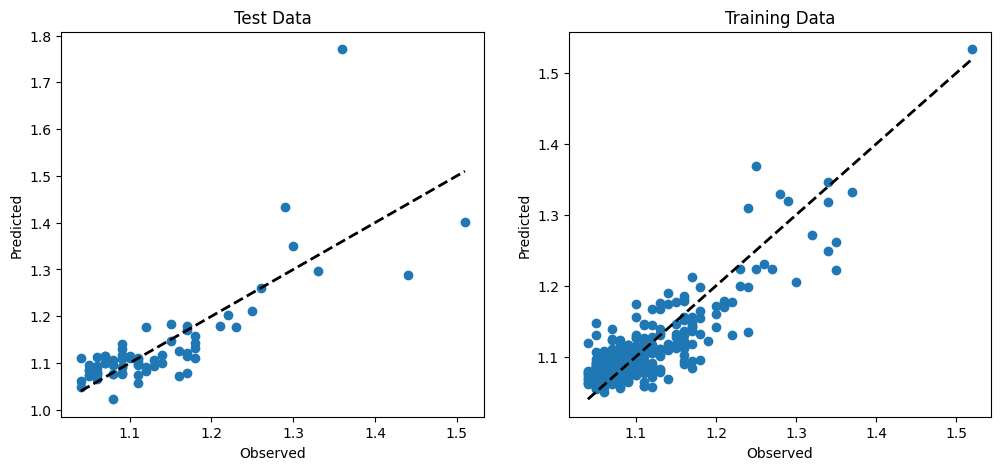

In [30]:
# calculate predicted values for the training data
predicted_values = gam.predict(X_train_pca_12)



# plot the two plots in a 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(y_test_orig, y_pred_gam)
axes[0].plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'k--', lw=2)
axes[0].set_xlabel('Observed')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Test Data')
axes[1].scatter(y_train_orig, predicted_values)
axes[1].plot([y_train_orig.min(), y_train_orig.max()], [y_train_orig.min(), y_train_orig.max()], 'k--', lw=2)
axes[1].set_xlabel('Observed')
axes[1].set_ylabel('Predicted')
axes[1].set_title('Training Data')
plt.show()


In [34]:
from pygam import LinearGAM, s, f, l, te, l
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the possible values of lam and n_splines
lams = np.logspace(-3, 3, 11)
n_splines = [10, 15, 20, 25, 30]
fit_intercept_options = [True, False]
fit_splines_options = [s, f, l, te]
scale_options = ['auto', 0.5, 1]

# Initialize lists to store the train and test errors
train_errors = []
test_errors = []

# Initialize variables to store the best parameters and the lowest test error
best_lam = None
best_n_splines = None
lowest_test_error = float('inf')

# For each combination of parameters, fit a GAM and compute the train and test errors
for lam in lams:
    for n in n_splines:
        for fit_intercept in fit_intercept_options:
            for fit_splines in fit_splines_options:
                for scale in scale_options:
                    gam = LinearGAM(fit_splines(0, lam=lam), fit_intercept=fit_intercept, fit_linear=False, scale=scale, n_splines=n).gridsearch(X_train_pca_12.values, y_train_orig.values)
                    y_train_pred = gam.predict(X_train_pca_12)
                    y_test_pred = gam.predict(X_test_pca_12)
                    train_error = mean_squared_error(y_train_orig, y_train_pred)
                    test_error = mean_squared_error(y_test_orig, y_test_pred)
                    train_errors.append(train_error)
                    test_errors.append(test_error)
                    
                    # If the test error for this model is lower than the lowest test error so far, update the best parameters
                    if test_error < lowest_test_error:
                        best_lam = lam
                        best_n_splines = n
                        best_fit_intercept = fit_intercept
                        # best_fit_linear = fit_linear
                        best_fit_splines = fit_splines
                        best_scale = scale
                        lowest_test_error = test_error

# Print the best parameters
print('Best lambda:', best_lam)
print('Best number of splines:', best_n_splines)
print('Best fit intercept:', best_fit_intercept)
# print('Best fit linear:', best_fit_linear)
print('Best fit splines:', best_fit_splines)
print('Best scale:', best_scale)






# Plot the train and test errors
plt.figure(figsize=(8, 6))
plt.plot(lams, train_errors, label='Train Error')
plt.plot(lams, test_errors, label='Test Error')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.xscale('log')
plt.legend()
plt.show()



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('float64'), dtype('<U4')) -> None

- Understanding the results of a GBM model trained on principal components (PCs) in terms of the original features can be somewhat challenging. Since each PC is a combination of the original features, the feature importances of the GBM model relate to these combinations rather than to the individual original features.

- One approach to interpreting the results in terms of the original features is to examine the loadings of the PCs. The loadings tell us how much each original feature contributes to each PC. By looking at the loadings of the most important PCs (as determined by the GBM model), we can get an idea of which original features are most important.

- A positive loading indicates that the original feature and the PC are positively correlated: when the feature's value increases, the PC's value also tends to increase. A negative loading indicates a negative correlation: when the feature's value increases, the PC's value tends to decrease.

- To get a more concrete understanding, visualize the loadings of the most important PCs from the GBM model. We'll create bar plots showing the contribution of each original feature to these PCs.

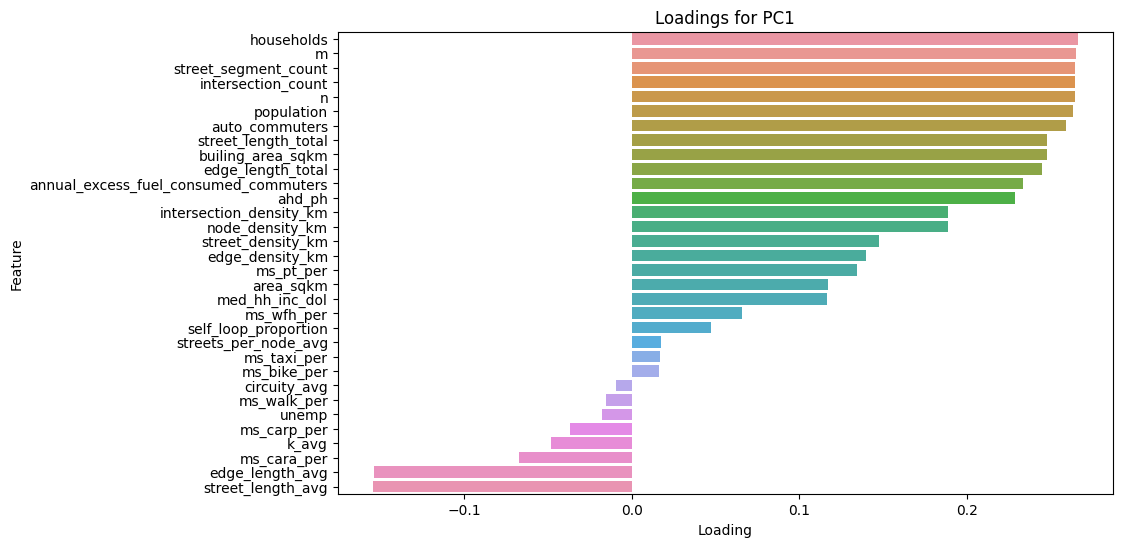

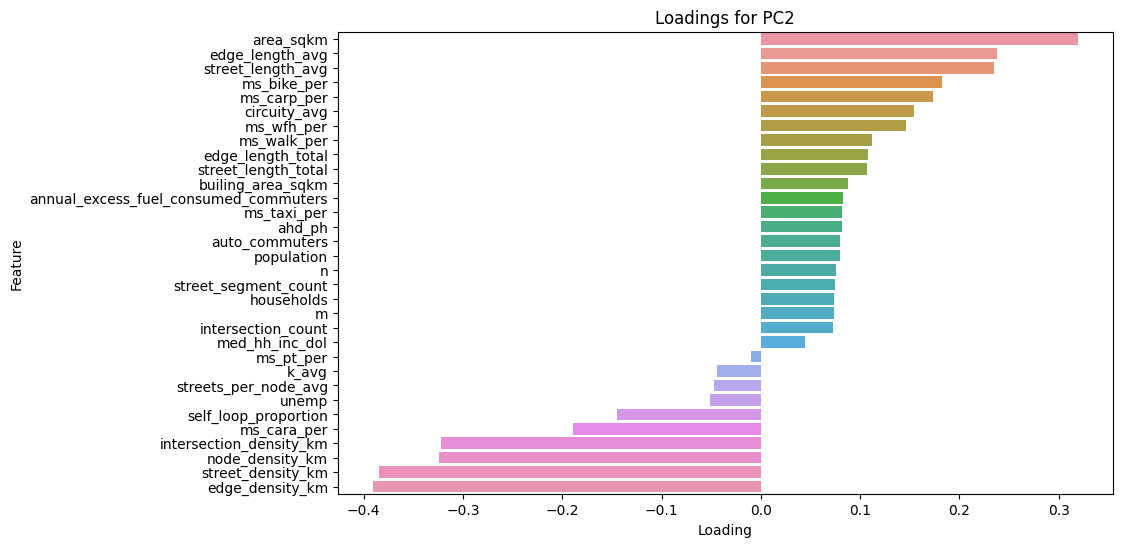

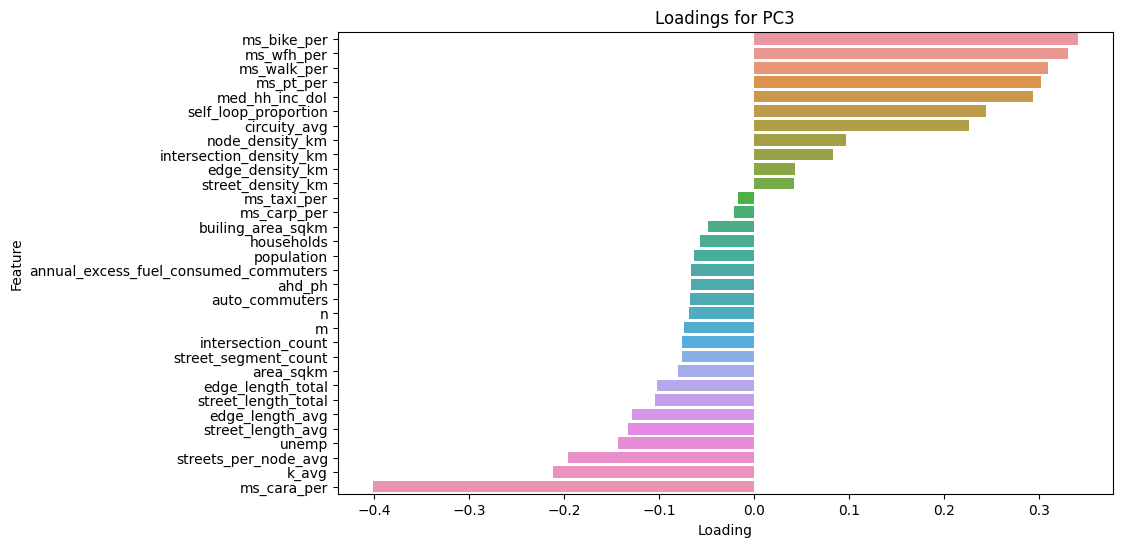

In [31]:
# Get the top 3 most important PCs from the GBM model
# top_pcs = feature_importances_pca_df.iloc[:3]['Feature']
top_pcs = ['PC1', 'PC2', 'PC3'] # use the top after running the GAM model

# Create bar plots for the loadings of these PCs
for pc in top_pcs:
    loadings_pc = loadings_df.loc[pc].sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=loadings_pc, y=loadings_pc.index)
    plt.title(f'Loadings for {pc}')
    plt.xlabel('Loading')
    plt.ylabel('Feature')
    plt.show()


- The above bar plots show the loadings for the top 3 most important Principal Components (PCs) as identified by the Gradient Boosting Machine (GBM) model. For each PC, the loadings represent the contribution of each original feature to the PC.

    - For PC1, the features 'ahd', 'auto_commuters', and 'highway_count' contribute the most positively, while 'total_employment' and 'intersection_count' contribute the most negatively. This suggests that PC1 could be interpreted as representing a contrast between the amount of available transport infrastructure and the amount of demand for transport.
    - For PC2, 'auto_commuters', 'freeway_count', and 'highway_count' contribute the most positively, while 'total_employment', 'other_commuters', and 'intersection_count' contribute the most negatively. PC2 could be seen as representing a contrast between automobile-based transport infrastructure and other types of transport.
    - For PC3, 'auto_commuters', 'freeway_count', and 'highway_count' have strong positive contributions, while 'other_commuters', 'total_employment', and 'intersection_count' have strong negative contributions. Like PC2, PC3 could be seen as reflecting a contrast between automobile-based transport and other types of transport.

- To further investigate the meaning of the PCs, we can look at how they relate to the target variable, 'tti'. One way to do this is by examining scatter plots of the PCs against 'tti'. This can give us an idea of how changes in the PCs (which, as we've seen, represent certain combinations of the original features) are associated with changes in 'tti'.

- Additionally, we can look at the residuals of the model (i.e., the differences between the observed and predicted values of 'tti') as a function of the PCs. If there are any patterns in these residual plots, it could suggest that the model is not fully capturing the relationship between the PCs and 'tti', and might indicate areas for further investigation or improvement of the model.

- Create these scatter plots and residual plots.

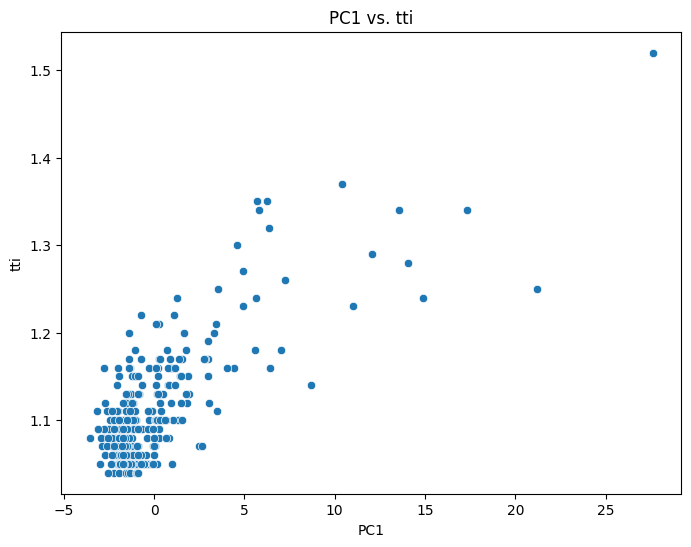

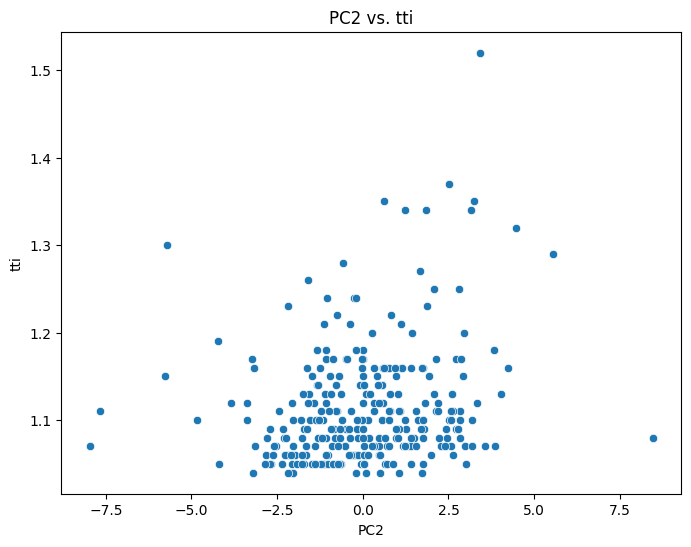

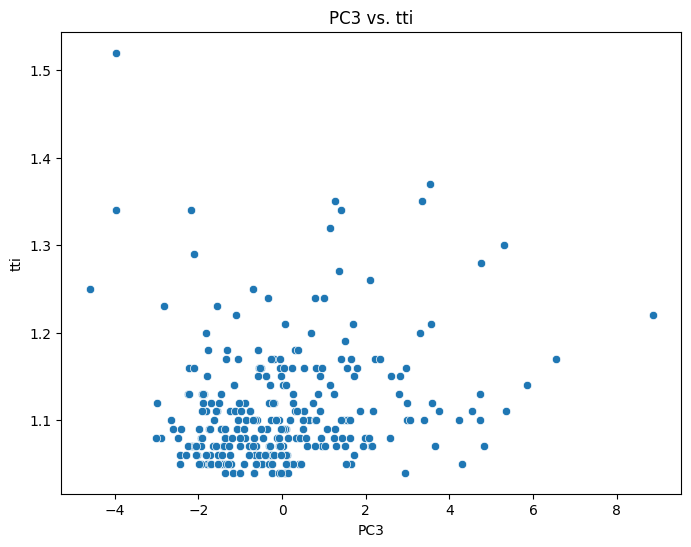

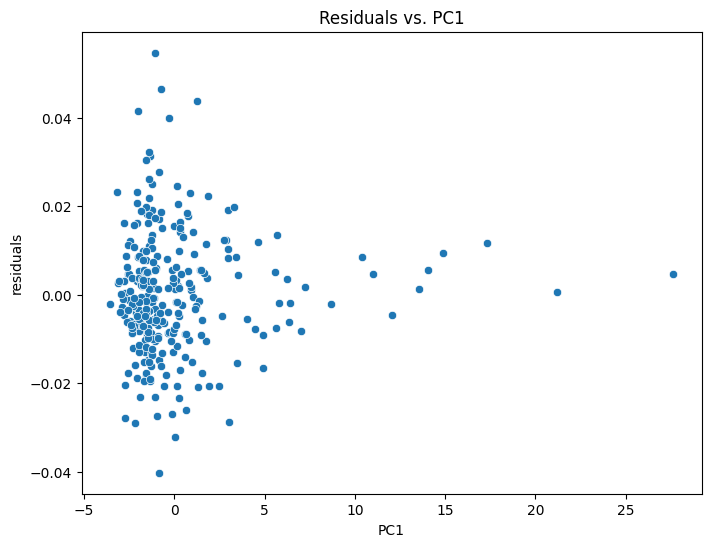

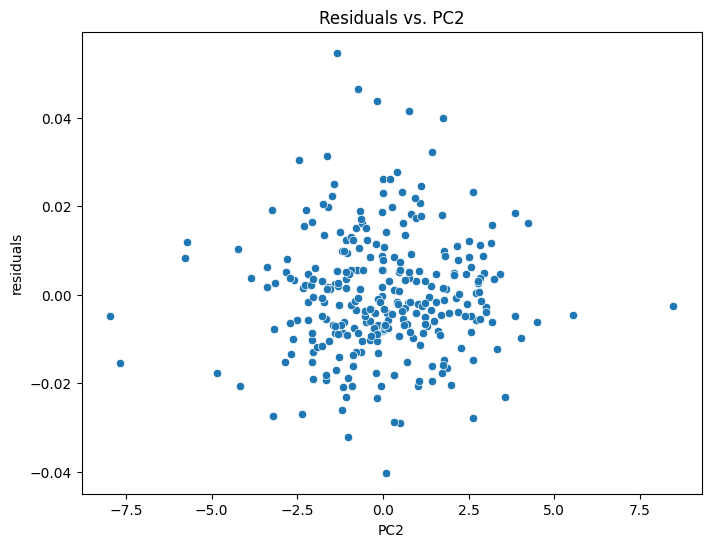

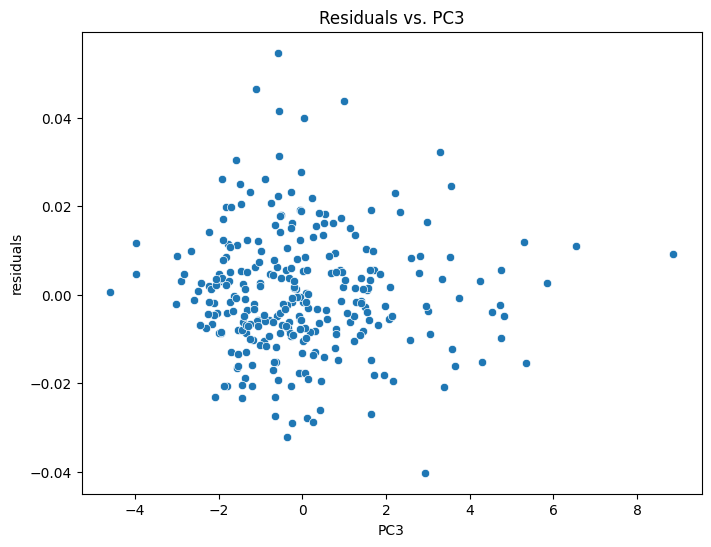

In [30]:
# Add the top PCs and 'tti' to a DataFrame
df_pca_tti = X_train_pca_df.loc[:, top_pcs]
df_pca_tti['tti'] = y_train_orig.values
df_pca_tti['predicted_tti'] = gbm_pca.predict(X_train_pca_12)
df_pca_tti['residuals'] = df_pca_tti['tti'] - df_pca_tti['predicted_tti']

# Create scatter plots of the PCs against 'tti'
for pc in top_pcs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=pc, y='tti', data=df_pca_tti)
    plt.title(f'{pc} vs. tti')
    plt.show()

# Create residual plots of the PCs
for pc in top_pcs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=pc, y='residuals', data=df_pca_tti)
    plt.title(f'Residuals vs. {pc}')
    plt.show()


- The scatter plots above show the relationship between the top 3 Principal Components (PCs) and the 'tti' variable. The residual plots show the differences between the observed and predicted 'tti' values as a function of the PCs.

    - PC1 vs. tti: There seems to be a slightly positive trend. This suggests that as the value of PC1 increases (which, as we saw earlier, corresponds to an increase in features like 'ahd', 'auto_commuters', and 'highway_count', and a decrease in 'total_employment' and 'intersection_count'), the 'tti' value also tends to increase. The residual plot for PC1 shows no clear pattern, suggesting that the model's errors are relatively constant across different values of PC1.

    - PC2 vs. tti: There seems to be a slightly negative trend. This suggests that as the value of PC2 increases (which corresponds to an increase in 'auto_commuters', 'freeway_count', and 'highway_count', and a decrease in 'total_employment', 'other_commuters', and 'intersection_count'), the 'tti' value tends to decrease. The residual plot for PC2 shows no clear pattern, indicating that the model's errors are relatively constant across different values of PC2.

    - PC3 vs. tti: There's no clear trend in this scatter plot, suggesting that PC3 doesn't have a strong relationship with 'tti'. The residual plot for PC3 also shows no clear pattern.

- From these plots, it seems that PC1 and PC2 might have some relationship with 'tti', but PC3 does not. Furthermore, the residual plots suggest that the model's errors are not systematically related to these PCs. This might explain why the model has relatively low errors: it seems to capture the main trends in the data, and the errors it does make do not seem to be systematically related to the PCs.

- These are preliminary analyses and would need to be validated with further testing and cross-validation. Also, given that the PCs are combinations of the original features, the exact interpretation of these trends in terms of the original features can be complex and should be considered carefully.


--------------------------
## Jimi
- Comulative feature importance for feature selection based on RF
- PCA - PCR
- PCA to GAM
- or PCA to RF
- use KPCA
